# Libraries

In [1]:
! pip install transformers
! pip install hazm
from hazm import *
import transformers
from transformers import AdamW
from transformers.optimization import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, roc_auc_score
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import json
from copy import deepcopy
import numpy as np
import random
import re
import string
import codecs
from shutil import copyfile
random.seed(12345)
label_encoder = preprocessing.LabelEncoder()

# Loading & Preprocessing data

In [3]:
news = pd.read_csv('AI_NEWS.csv')
news

,Unnamed: 0,index,title,text,category,keywords,source_name,data,tag
0,0,2000,لیگ قهرمانان آسیا| استقلال ایران 3 - الشرطه عر...,NaN,ورزشی,لیگ قهرمانان آسیا| استقلال ایران - الشرطه عراق...,جماران,1463620,غیر مهم
1,1,2001,سویه لامبدا؛ خیلی دور، خیلی نزدیک!/ هر آنچه که...,NaN,اقتصادی,NaN,آنا,3041187,غیر مهم
2,2,2002,افزایش تحرکات هیات ها در مذاکرات وین؛ تحولاتی ...,به گزارش خبرنگار ایرنا از وین، آهنگ رفت و آمد ...,بین الملل,"وین,کمیسیون مشترک برجام,علی باقری,مذاکرات برای...",ایرنا,4132788,مهم
3,3,2003,ناکارآمدی بازرگانی محصولات کشاورزی ناشی از ناک...,به گزارش خبرگزاری فارس از تبریز، اکبر فتحی در ...,اقتصادی,"کشاورزی,آذربایجان شرقی,کشاورزان,محصولات,کشت فر...",خبرگزاری فارس,3652101,غیر مهم
4,4,2004,طالبان: بدنبال روابط خوب با همه کشورها از جمله...,به گزارش دفتر منطقه ای خبرگزاری تسنیم، «ذبیح ا...,بین الملل,NaN,خبرگزاری تسنیم,3846298,غیر مهم
...,...,...,...,...,...,...,...,...,...
3995,3995,8972,درگیری شدید شبه نظامیان امارات و عربستان در اس...,به گزارش گروه بین الملل خبرگزاری تسنیم به نقل ...,بین الملل,NaN,خبرگزاری تسنیم,2263257,غیر مهم
3996,3996,8973,امام خمینی (ره) بیش از ایران در جهان موثر بود...,به گزارش خبرنگار خبرگزاری شبستان از شیراز، اند...,فرهنگ و هنر,NaN,شبستان,1967520,غیر مهم
3997,3997,8974,مادری که رهبر انقلاب برایش دعا کردند کیست؟/ قر...,گروه خانواده؛ نعیمه موحد: دیدار دانشجویی امسال...,فرهنگ و هنر,"حضرت آیت الله خامنه ای,جنبش دانشجویی,خبر خوب,...",خبرگزاری فارس,1748716,غیر مهم
3998,3998,8975,\t\t \t\t\tلحظه دلهره آور نجات سگی که در یخبن...,به گزارش خبرنگار حوزه اخبار داغ گروه فضای مجاز...,فناوری و ارتباطات,نجات سگ \t\t\t\t\t، \t\t\...,باشگاه خبرنگاران,61151,غیر مهم


In [4]:
class Preprocessing:

  @staticmethod
  def remove_punctuations(text):
    new_text = []
    for l in text:
      if l not in string.punctuation + '\u00AB' + '\u00BB' + '\u060C' + '\u061B' + '\u061F':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)
  
  @staticmethod
  def remove_numbers(text):
    new_text = []
    for l in text:
      if l not in '0123456789۰۱۲۳۴۵۶۷۸۹':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)

  @staticmethod
  def remove_stopwords(text):
    normalizer = Normalizer()
    stopwords = [normalizer.normalize(x.strip()) for x in codecs.open('stopwords.txt','r','utf-8').readlines()]
    tokens = word_tokenize(text)
    new_text = []
    for token in tokens:
      if token not in stopwords:
        new_text.append(token)
      else:
        new_text.append(' ')
    return ' '.join(new_text)

  @staticmethod
  def remove_extra_space(text):
    new_text = re.sub(r'\s+',' ',text)
    return new_text

In [5]:
# a class to hold our data structure
class Data:
  def __init__(self, data, preprocessing=False):
    self.title = data['title']
    self.text = data['text']
    self.category = data['category']
    self.label = label_encoder.transform([data['tag']])[0]

# label encoder
all_labels = ['مهم','غیر مهم']
label_encoder.fit(all_labels)
classes = label_encoder.classes_

# convert raw data into Data objects
news_data = []
for index, data in news.iterrows():
  news_data.append(Data(data, True))

In [6]:
def split_data(data, portions=[.6,.2,.2]):
  random.shuffle(data)
  data_len = len(data)
  train_data = data[:int(portions[0] * data_len)]
  eval_data = data[int(portions[0] * data_len):int((portions[0] + portions[1]) * data_len)]
  test_data = data[int((portions[0] + portions[1]) * data_len):]
  return train_data, eval_data, test_data

In [7]:
# a function to get a portion of data with acquired preprocessings
def get_data(dataset, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True}):
  random.shuffle(dataset)
  new_dataset = []

  # applying preprocessings on train data
  for i, data in enumerate(tqdm(dataset)):
    if str(data.text) == 'nan':
      continue
    if preprocess['remove_stopwords'] == True:
      dataset[i].text = Preprocessing.remove_stopwords(data.text)
    if preprocess['remove_punctuations'] == True:
      dataset[i].text = Preprocessing.remove_punctuations(data.text)
    if preprocess['remove_numbers'] == True:
      dataset[i].text = Preprocessing.remove_numbers(data.text)
    dataset[i].text = Preprocessing.remove_extra_space(data.text)
    new_dataset.append(dataset[i])

  return split_data(new_dataset)

# Roberta

In [8]:
train_data, eval_data, test_data = get_data(news_data, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True})

100%|██████████| 4000/4000 [01:16<00:00, 51.99it/s]


## Load Bert

In [9]:
# loading pars roberta and tokenizer
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel
# v3.0
model_name_or_path = "HooshvareLab/bert-fa-zwnj-base"
config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
# model = TFAutoModel.from_pretrained(model_name_or_path)  For TF
parsbert = AutoModel.from_pretrained(model_name_or_path)

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.poo

## Transformer Dataloader

In [10]:
# a class for loading data
class NewsDataloader(Dataset):

  def __init__(self,dataset,tokenizer):
    self.dataset = dataset
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    text_tokens = self.tokenizer.encode_plus(
        str(self.dataset[idx].title),
        str(self.dataset[idx].text),
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_tensors="pt",
        truncation=True
    )

    return [text_tokens, self.dataset[idx].label]

In [11]:
# defining our transformer model
class TransformerModel(nn.Module):

  def __init__(self, bert):
    super(TransformerModel, self).__init__()
    self.bert = bert
    # we only use one linear head on the parsbert
    self.linear_head = nn.Linear(768, len(label_encoder.classes_))

  def forward(self, x):
    # main task
    x = self.bert(x['input_ids'],x['attention_mask'])
    logits = self.linear_head(x.pooler_output)
    return logits

## Training Transformer

In [12]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# Transformer Training
epochs = 2
lr = 8e-6
device = 'cuda:0'
k_step_loss = 0
k = 50
batch_size = 11
# get train dataloader
train_dataset = NewsDataloader(train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# get train dataloader
eval_dataset = NewsDataloader(eval_data, tokenizer)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)
# get eval dataloader
num_steps = int(np.ceil(len(train_dataloader.dataset) / batch_size))
loss_collection = []
f1_collection = []
eval_f1_micro = []
eval_f1_macro = []
eval_accuracy = []
model = TransformerModel(parsbert).to(device)
loss_fn = nn.CrossEntropyLoss(torch.tensor([.3, 1])).to(device)
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, 
    num_training_steps=epochs * len(train_dataloader.dataset)
)


for epoch in range(epochs):
  for step, data in enumerate(train_dataloader):
    input_ids = data[0]["input_ids"].squeeze().to(device)
    attention_mask = data[0]["attention_mask"].squeeze().to(device)
    labels = data[1].to(device)
    feed_dict = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    optimizer.zero_grad()
    output = model(feed_dict)
    loss = loss_fn(output, labels)
    # loss scheduler
    loss.backward()
    optimizer.step()
    scheduler.step()
    k_step_loss += loss.item()
    if (step + 1) % k == 0:
      loss_collection.append(k_step_loss)
      print(f'EPOCH {epoch + 1}/{epochs} | STEP [{step + 1}/{num_steps}] | Loss {k_step_loss}')
      k_step_loss = 0

  k_step_loss = 0
  print(f'################## Epoch {epoch + 1} Evaluation ##################')
  with torch.no_grad():
    all_pred = []
    all_label = []
    for j, data in enumerate(eval_dataloader):
      input_ids = data[0]["input_ids"].squeeze().to(device)
      attention_mask = data[0]["attention_mask"].squeeze().to(device)
      labels = data[1].to(device)
      feed_dict = {
          'input_ids': input_ids,
          'attention_mask': attention_mask
      }
      output = model(feed_dict)
      pred = output.argmax(dim=1, keepdim=True)
      all_label.extend(list(labels.cpu().numpy()))
      all_pred.extend(list(pred.view(-1).cpu().numpy()))


    f1_macro = f1_score(all_label, all_pred, average='macro')
    f1_micro = f1_score(all_label, all_pred, average='micro')
    accuracy = accuracy_score(all_label, all_pred)
    recall = recall_score(all_label, all_pred)
    roc_auc = roc_auc_score(all_label, all_pred)

    print(f'ROC-AUC {roc_auc}')
    print(f'F1-macro {f1_macro}')
    print(f'F1-micro {f1_micro}')
    print(f'Accuracy {accuracy}')
    print(f'Recall {recall}')
    f1_collection.append(f1_macro)
    eval_f1_macro.append(f1_macro)
    eval_f1_micro.append(f1_micro)
    eval_accuracy.append(accuracy)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 1/3 | STEP [50/207] | Loss 30.315733447670937
EPOCH 1/3 | STEP [100/207] | Loss 29.86525559425354
EPOCH 1/3 | STEP [150/207] | Loss 28.404585853219032
EPOCH 1/3 | STEP [200/207] | Loss 25.138344153761864
################## Epoch 1 Evaluation ##################
ROC-AUC 0.5559741248097412
F1-macro 0.5671137450613433
F1-micro 0.8546895640686922
Accuracy 0.8546895640686922
Recall 0.15


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 2/3 | STEP [50/207] | Loss 21.764258340001106
EPOCH 2/3 | STEP [100/207] | Loss 20.105327874422073
EPOCH 2/3 | STEP [150/207] | Loss 21.78496688604355
EPOCH 2/3 | STEP [200/207] | Loss 20.204062059521675
################## Epoch 2 Evaluation ##################
ROC-AUC 0.5743455098934551
F1-macro 0.5947023011155084
F1-micro 0.8718626155878466
Accuracy 0.8718626155878467
Recall 0.17


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 3/3 | STEP [50/207] | Loss 15.3994702398777
EPOCH 3/3 | STEP [100/207] | Loss 13.405286055058241
EPOCH 3/3 | STEP [150/207] | Loss 13.106950916349888
EPOCH 3/3 | STEP [200/207] | Loss 12.54720040410757
################## Epoch 3 Evaluation ##################
ROC-AUC 0.6428158295281583
F1-macro 0.6428158295281583
F1-micro 0.8361955085865258
Accuracy 0.8361955085865258
Recall 0.38


## Drawing Loss & Validation F1

Text(0, 0.5, 'f1-macro')

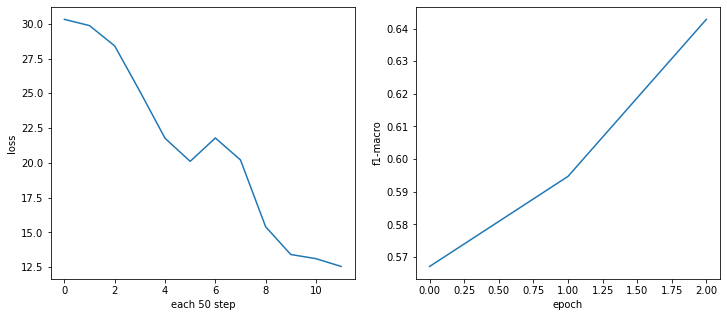

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(range(len(loss_collection)), loss_collection)
plt.xlabel(f'each {k} step')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(range(len(f1_collection)), f1_collection)
plt.xlabel(f'epoch')
plt.ylabel('f1-macro')

## Tesing

In [15]:
# test dataloader
test_dataset = NewsDataloader(test_data, tokenizer)
batch_size = 11
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

with torch.no_grad():
  all_pred = []
  all_label = []
  for j, data in enumerate(test_dataloader):
    input_ids = data[0]["input_ids"].squeeze().to(device)
    attention_mask = data[0]["attention_mask"].squeeze().to(device)
    labels = data[1].to(device)
    feed_dict = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }
    output = model(feed_dict)
    pred = output.argmax(dim=1, keepdim=True)
    all_label.extend(list(labels.cpu().numpy()))
    all_pred.extend(list(pred.view(-1).cpu().numpy()))


  f1_macro = f1_score(all_label, all_pred, average='macro')
  f1_micro = f1_score(all_label, all_pred, average='micro')
  accuracy = accuracy_score(all_label, all_pred)
  recall = recall_score(all_label, all_pred)
  roc_auc = roc_auc_score(all_label, all_pred)

  print(f'ROC-AUC {roc_auc}')
  print(f'F1-macro {f1_macro}')
  print(f'F1-micro {f1_micro}')
  print(f'Accuracy {accuracy}')
  print(f'Recall {recall}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


ROC-AUC 0.6299487818383167
F1-macro 0.6247300916607057
F1-micro 0.8031704095112285
Accuracy 0.8031704095112285
Recall 0.38392857142857145


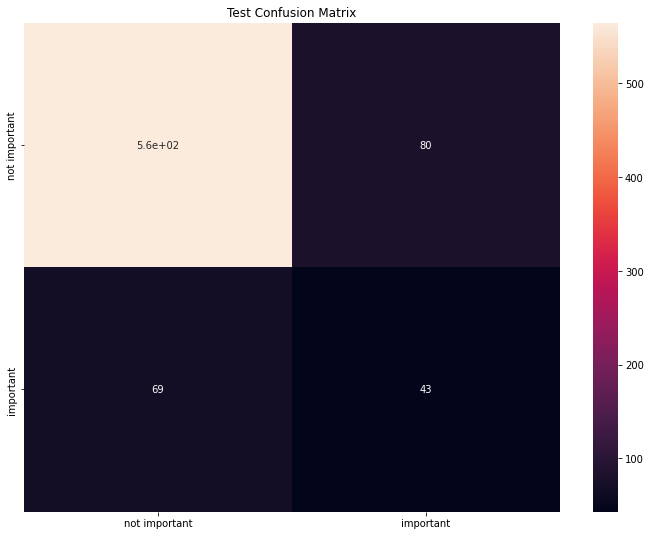

In [16]:
# confusion matrix for test data
classes = ['not important', 'important']
c_mat = confusion_matrix(all_label, all_pred)
df_cm = pd.DataFrame(c_mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (12,9))
plt.title('Test Confusion Matrix')
sn.heatmap(df_cm, annot=True)
plt.savefig('roberta_conf.jpg', dpi=400)

In [17]:
# save model
from google.colab import drive  
drive.mount('/content/drive')
torch.save(model, 'drive/MyDrive/project_bert.pth')

Mounted at /content/drive


# Load & Use Model